### **Deutsch–Jozsa Algorithm**

The Deutsch–Jozsa algorithm determines whether a hidden function $f: \{0,1\}^n \to \{0,1\}$ is constant or balanced.

<br>

---



**1. Building the Oracle**

The oracle must implement the transformation:
$$|x, y\rangle \to |x, \, y \oplus f(x)\rangle$$

We randomly generate a function that satisfies the Deutsch–Jozsa promise:

 - Constant Case (50% chance)
    * $f(x) = 0$ => do nothing!
    * $f(x) = 1$ => apply $X$ gate to the ancilla qubit.

<br>

- Balanced Case (50% chance)
    1.  Randomly choose half of all possible input bitstrings where $f(x) = 1$.
    2.  For each such input:
        * Temporarily transform that basis state using $X$ gates.
        * Apply a multi-controlled NOT to flip the ancilla.
        * Undo the temporary $X$ gates.

---

<br>

**2. Decision Rule**

After measurement:
 - All input qubits = 0     =>  CONSTANT!
 - Any input qubit = 1      =>  BALANCED!

---


In [214]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit_aer import AerSimulator

num_of_qubits = 5

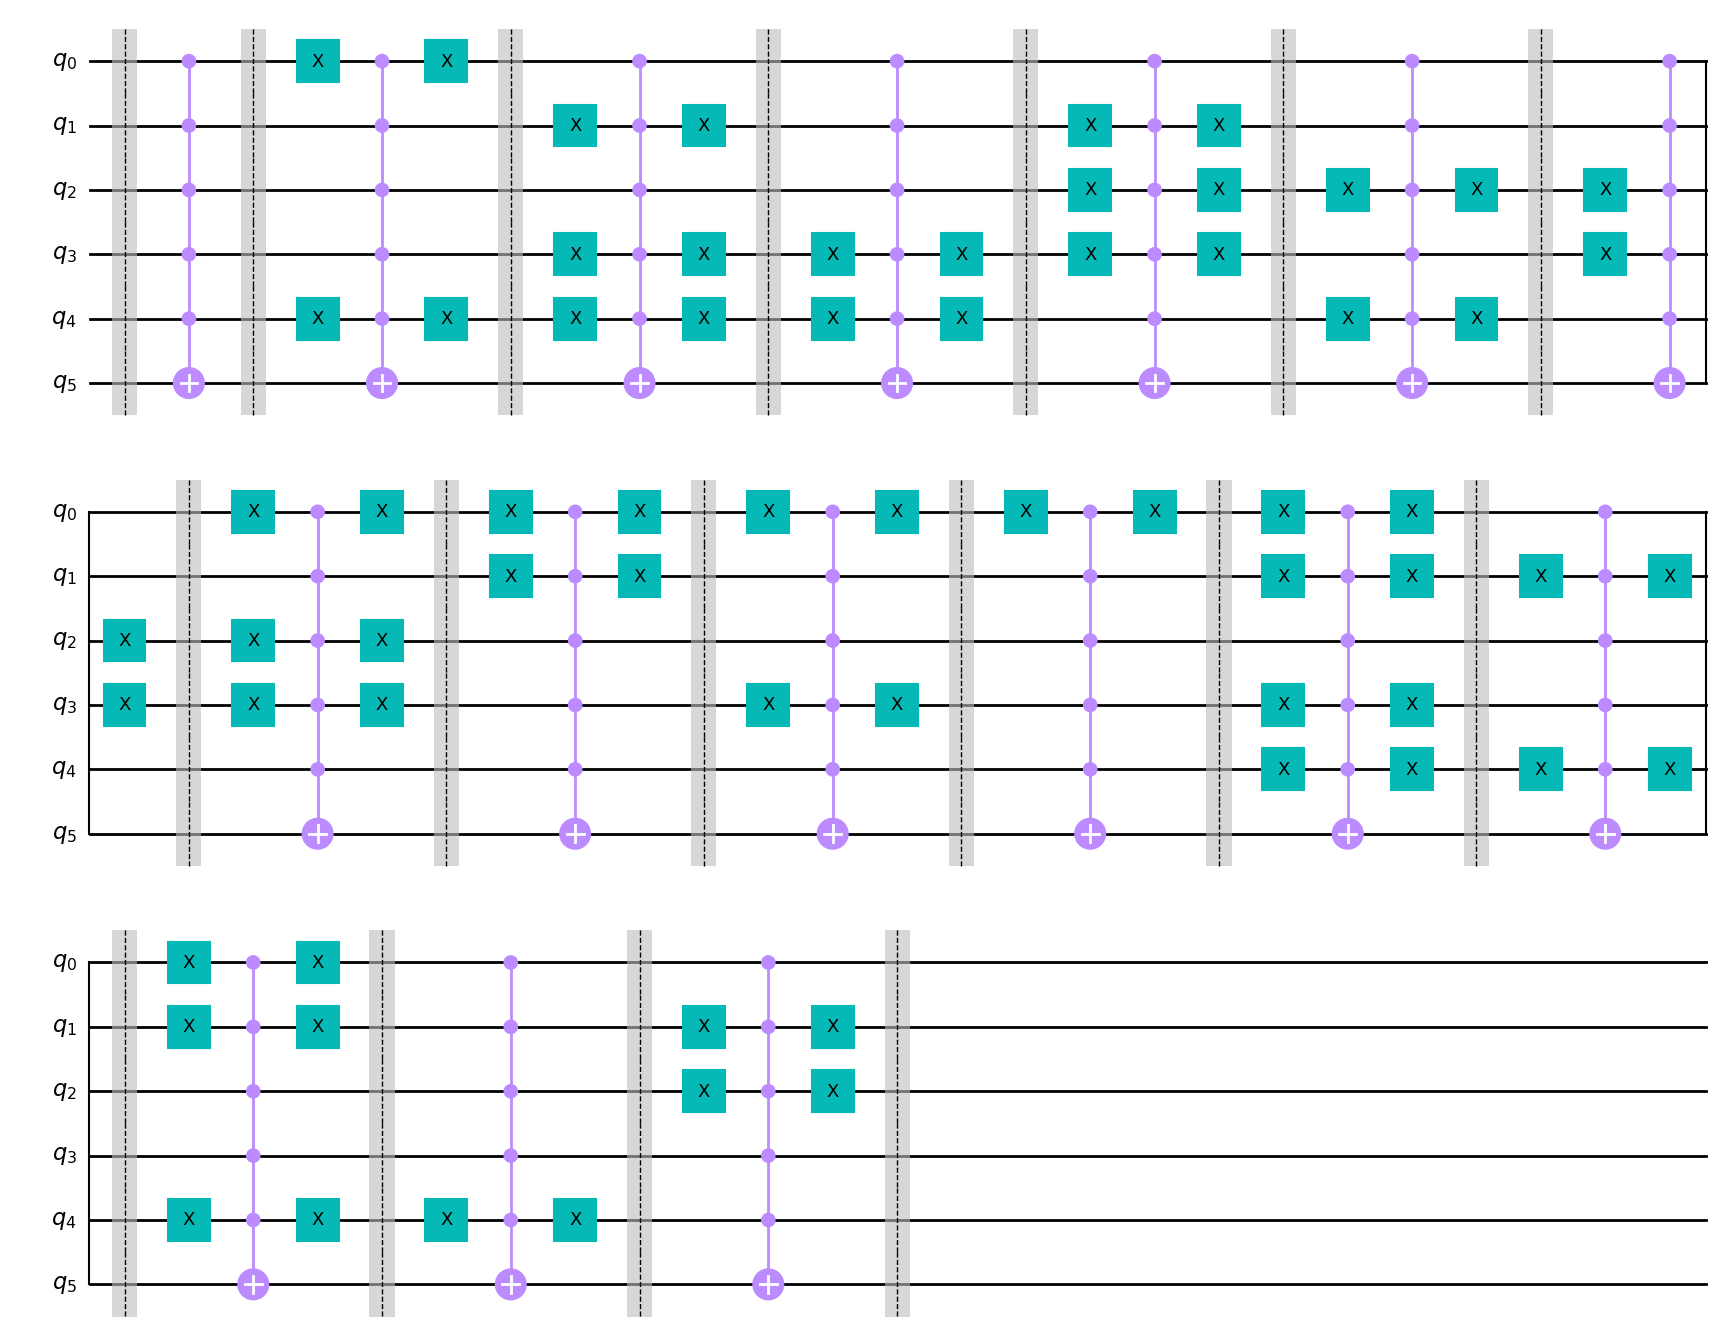

In [215]:

# -------------------------------------------------------
# 1. Build Deutsch–Jozsa Oracle
# -------------------------------------------------------

def build_dj_oracle(n):
    qc = QuantumCircuit(n + 1)

    # -------------------------------------------------------
    # 1. CONSTANT FUNCTION (50% chance)
    # -------------------------------------------------------
    # choose constant vs balanced
    if np.random.randint(0, 2):
        if np.random.randint(0, 2):
            qc.x(n)                 # f(x) = 1 → flip nth qubit
        # else: f(x) = 0 → do nothing
        return qc

    # -------------------------------------------------------
    # 2. BALANCED FUNCTION (50% chance)
    # -------------------------------------------------------
    # Choose exactly half of all input strings where f(x) = 1
    on_states = np.random.choice(
        range(2 ** n),
        2 ** n // 2,
        replace=False,
    )

    # Helper: flips qubits based on bitstring
    def encode_state(qc, bitstring):
        for qubit, bit in enumerate(reversed(bitstring)):
            if bit == "1":
                qc.x(qubit)
        return qc

    # Build the oracle
    for state in on_states:
        qc.barrier()
        bitstring = f"{state:0{n}b}"
        qc = encode_state(qc, bitstring)
        qc.mcx(list(range(n)), n)
        qc = encode_state(qc, bitstring)

    qc.barrier()
    return qc

build_dj_oracle(num_of_qubits).draw("mpl")



In [216]:
# -------------------------------------------------------
# 2. Deutsch–Jozsa circuit construction
# -------------------------------------------------------

def dj_circuit(function: QuantumCircuit):
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)

    # Step 1: prepare ancilla in |1>
    qc.x(n)
    qc.barrier()

    # Step 2: apply Hadamards to all qubits
    qc.h(range(n + 1))

    # Step 3: apply the oracle
    qc.compose(function, inplace=True)

    # Step 4: apply Hadamard to input qubits
    qc.h(range(n))
    qc.barrier()

    # Step 5: measure input qubits
    qc.measure(range(n), range(n))

    return qc



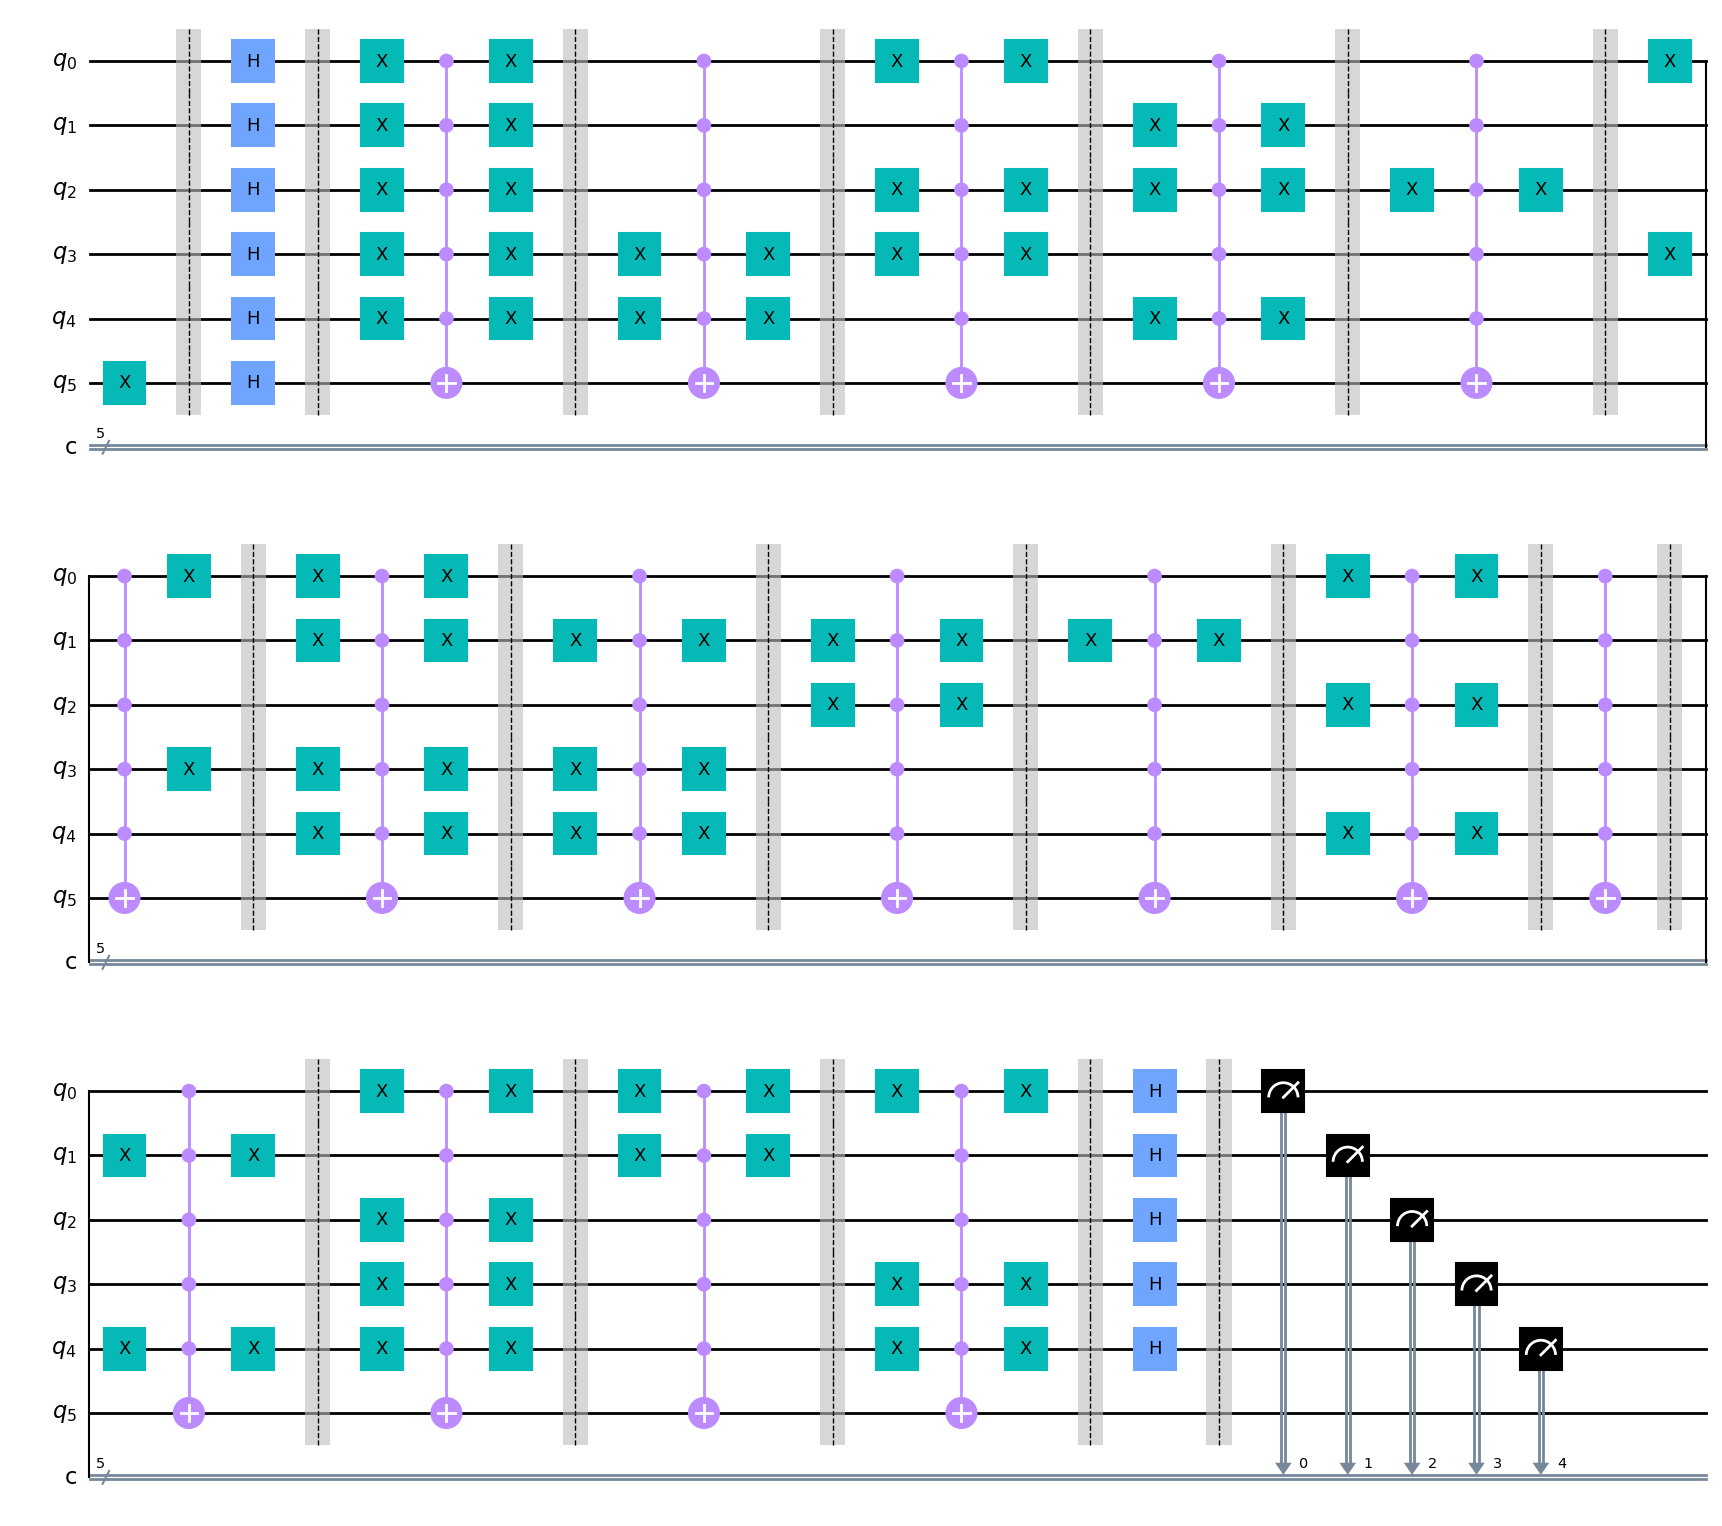

In [217]:
qc = dj_circuit(build_dj_oracle(num_of_qubits))
qc.draw("mpl")

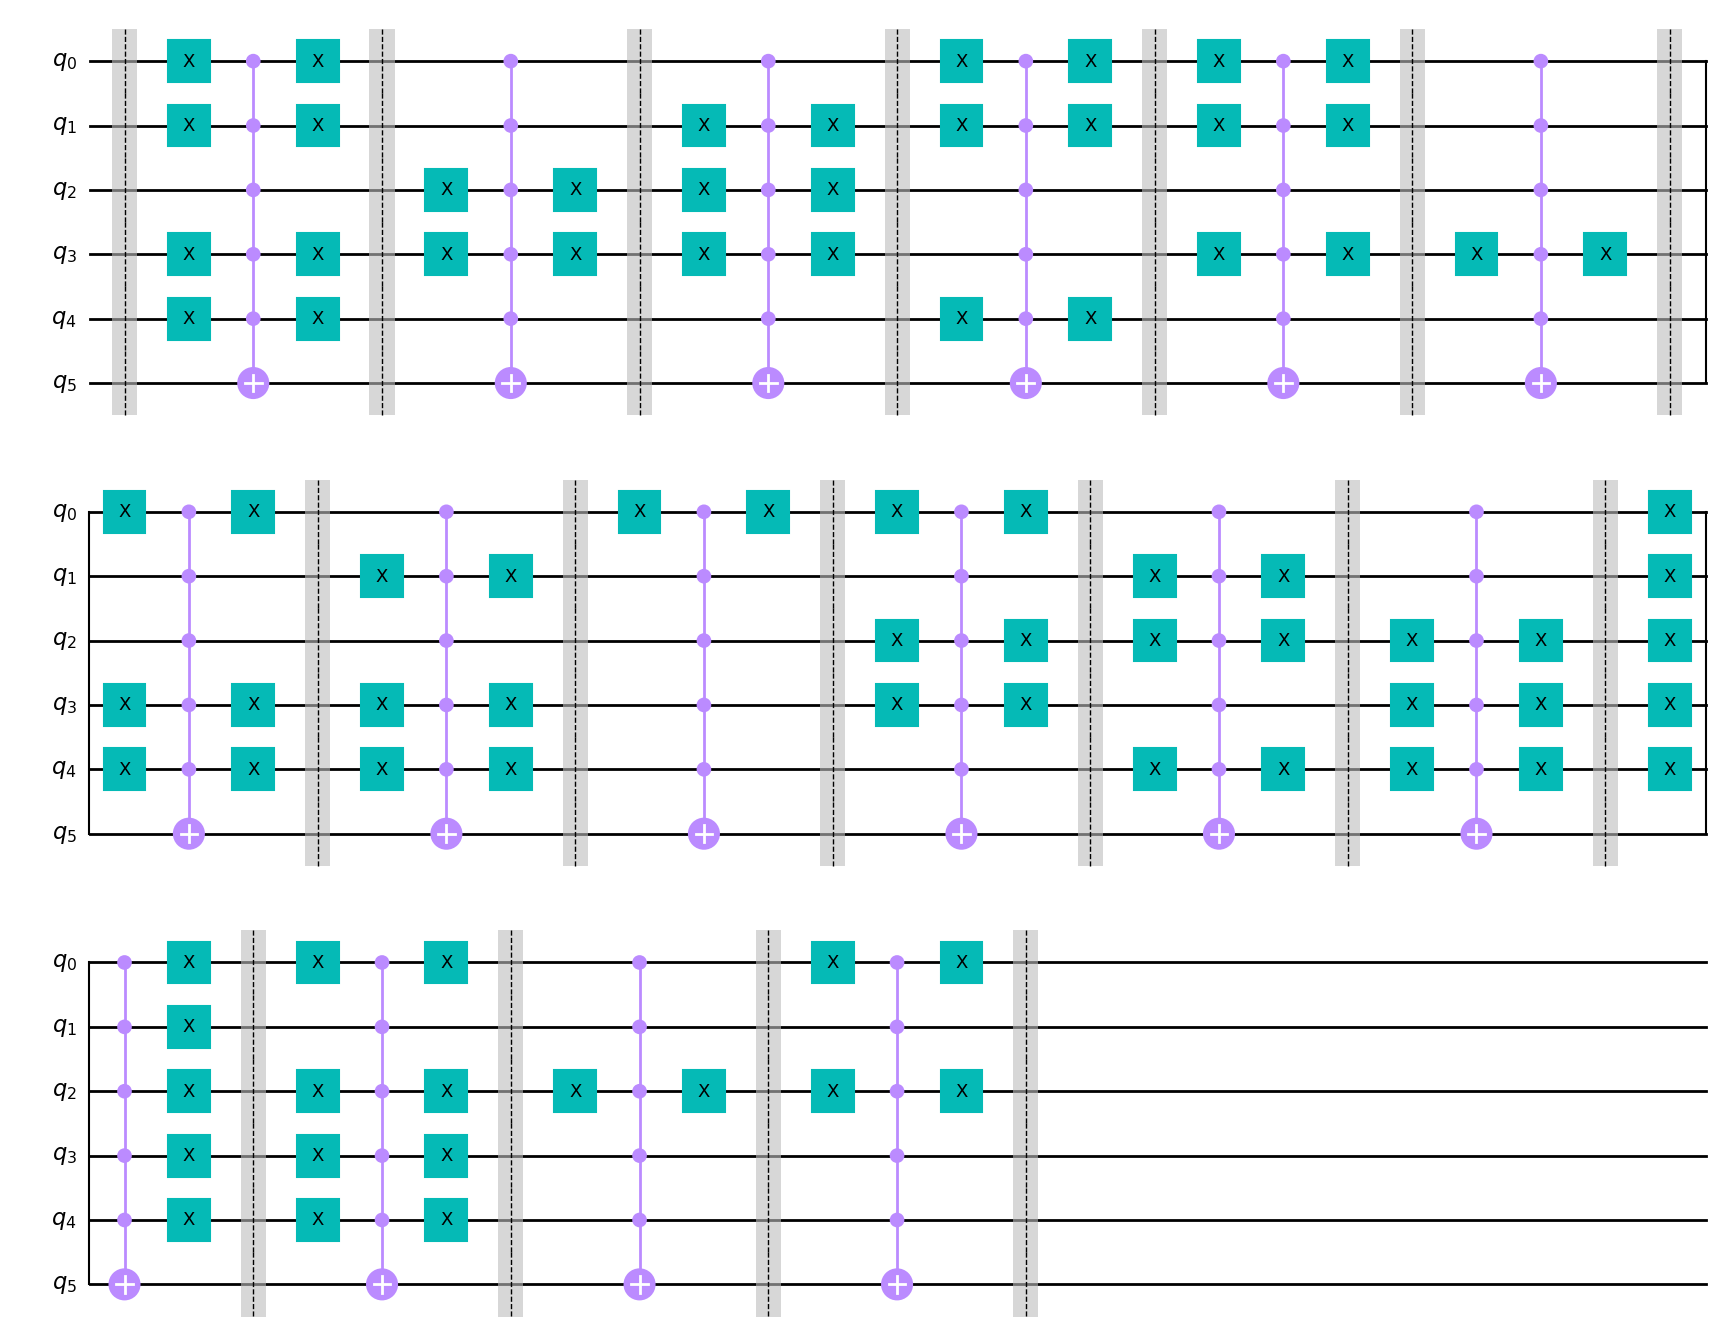

DJ Result: balanced


In [218]:

# -------------------------------------------------------
# 3. Deutsch–Jozsa algorithm
# -------------------------------------------------------

def run_dj(function: QuantumCircuit):
    qc = dj_circuit(function)

    sim = AerSimulator()
    result = sim.run(qc, shots=1, memory=True).result()
    measurement = result.get_memory()[0]

    # If all measurements = 0 → constant
    if set(measurement) == {"0"}:
        return "constant"
    else:
        return "balanced"


# -------------------------------------------------------
# 4. Test with 5-qubit oracle
# -------------------------------------------------------

oracle = build_dj_oracle(num_of_qubits)
display(oracle.draw("mpl"))
print("DJ Result:", run_dj(oracle))
